<a href="https://colab.research.google.com/github/xerifg/Myipynb/blob/main/3d_pose_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install progress

In [ ]:
from progress.bar import Bar
import torch
import torch.nn as nn
import torch.optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.autograd import Variable

from __future__ import print_function, absolute_import, division
import os
import sys
import time
import numpy as np

In [ ]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal(m.weight)

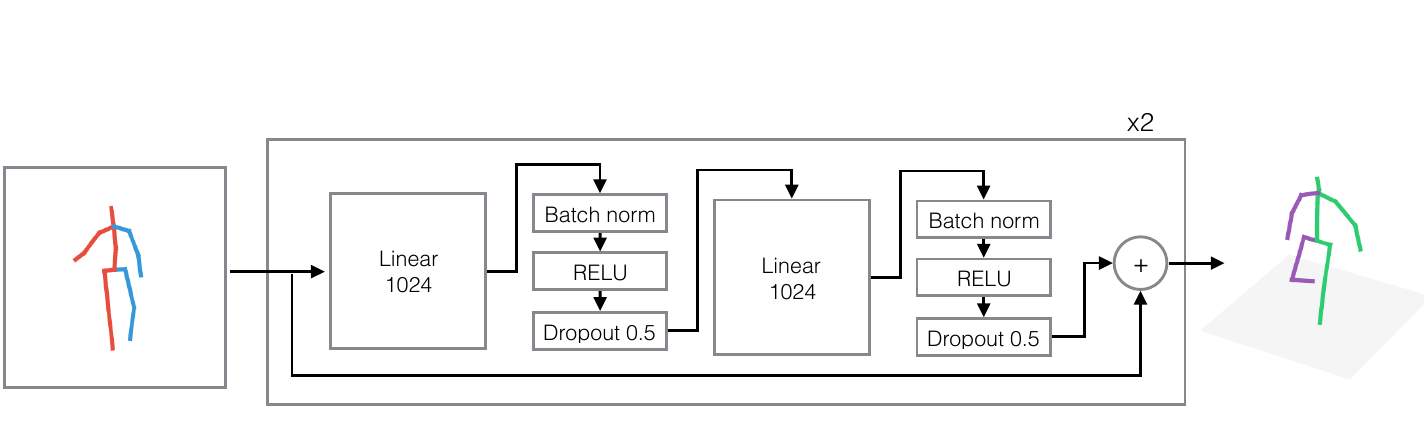

In [ ]:
class Linear(nn.Module):
    def __init__(self, linear_size, p_dropout=0.5):
        super(Linear, self).__init__()
        self.l_size = linear_size

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p_dropout)

        self.w1 = nn.Linear(self.l_size, self.l_size)
        self.batch_norm1 = nn.BatchNorm1d(self.l_size)

        self.w2 = nn.Linear(self.l_size, self.l_size)
        self.batch_norm2 = nn.BatchNorm1d(self.l_size)

    def forward(self, x):
        y = self.w1(x)
        y = self.batch_norm1(y)
        y = self.relu(y)
        y = self.dropout(y)

        y = self.w2(y)
        y = self.batch_norm2(y)
        y = self.relu(y)
        y = self.dropout(y)

        out = x + y

        return out


In [ ]:
class LinearModel(nn.Module):
    def __init__(self,
                 linear_size=1024,
                 num_stage=2,
                 p_dropout=0.5):
        super(LinearModel, self).__init__()

        self.linear_size = linear_size
        self.p_dropout = p_dropout
        self.num_stage = num_stage

        # 2d joints
        self.input_size =  17 * 2
        # 3d joints
        self.output_size = 17 * 3

        # process input to linear size
        self.w1 = nn.Linear(self.input_size, self.linear_size)
        self.batch_norm1 = nn.BatchNorm1d(self.linear_size)

        self.linear_stages = []
        for l in range(num_stage):
            self.linear_stages.append(Linear(self.linear_size, self.p_dropout))
        self.linear_stages = nn.ModuleList(self.linear_stages)  ## 组装模型的容器，容器内的模型只是被存储在ModelList里并没有像nn.Sequential那样严格的模型与模型之间严格的上一层的输出等于下一层的输入

        # post processing
        self.w2 = nn.Linear(self.linear_size, self.output_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(self.p_dropout)

    def forward(self, x):
        # pre-processing
        y = self.w1(x)
        y = self.batch_norm1(y)
        y = self.relu(y)
        y = self.dropout(y)

        # linear layers
        for i in range(self.num_stage):
            y = self.linear_stages[i](y)
        # post processing
        y = self.w2(y)

        return y

# 初始化模型参数

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = LinearModel().to(device)  # 初始化模型
model.apply(weight_init) # 初始化模型参数
criterion = nn.MSELoss(size_average=True).cuda() # 均方损失，size_average=True ： 返回loss.mean()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 学习率：0.001

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# 加载数据集

In [ ]:
class DealDataset(Dataset):
    def __init__(self,fname):
        (inp,tar) = torch.load(os.path.join('/content/drive/MyDrive/datasets/3Dpose', fname))  # 读取数据
        self.x_data = torch.from_numpy(inp)  # from numpy to sensor
        self.y_data = torch.from_numpy(tar)
        self.len = tar.shape[0]
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
Dataset_train = DealDataset('train.pth.tar')
Dataset_test = DealDataset('test.pth.tar')

In [ ]:
train_loader = DataLoader(
        dataset=Dataset_train,
        batch_size=64,
        shuffle=True,
        num_workers=8,
        pin_memory=True)
test_loader = DataLoader(
        dataset=Dataset_test,
        batch_size=64,
        shuffle=True,
        num_workers=8,
        pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# for epoch in range(2):
#   for i, data in enumerate(train_loader):
#       input, target = data
#       input, target = Variable(input), Variable(target)
#       print(epoch,i,"input: ",input.data.size(),"target: ",target.data.size())

# 训练网络阶段

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def LR_decay(optimizer, step, lr, decay_step, gamma):
    lr = lr * gamma ** (step/decay_step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

# 训练模块

In [ ]:
def train(train_loader, model, criterion, optimizer,
          lr_init=None, lr_now=None, glob_step=None, lr_decay=None, gamma=None,
          max_norm=True):
  
    losses = AverageMeter()

    model.train()

    start = time.time()
    batch_time = 0
    bar = Bar('>>>', fill='>', max=len(train_loader))

    for i, (inps, tars) in enumerate(train_loader):
        glob_step += 1
        if glob_step % lr_decay == 0 or glob_step == 1:
            lr_now = LR_decay(optimizer, glob_step, lr_init, lr_decay, gamma)
        inputs = Variable(inps.cuda())
        targets = Variable(tars.cuda(non_blocking=True))

        outputs = model(inputs)

        # calculate loss
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        loss.backward()
        if max_norm:
            nn.utils.clip_grad_norm(model.parameters(), max_norm=1)  #设置一个梯度剪切的阈值，如果在更新梯度的时候，梯度超过这个阈值，则会将其限制在这个范围之内，防止梯度爆炸
        optimizer.step()

        # update summary
        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.4f}' \
            .format(batch=i + 1,
                    size=len(train_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()

    bar.finish()
    return glob_step, lr_now, losses.avg

# 测试模块

In [ ]:
def test(test_loader, model, criterion):
    losses = AverageMeter()

    model.eval()

    all_dist = []
    start = time.time()
    batch_time = 0
    bar = Bar('>>>', fill='>', max=len(test_loader))

    for i, (inps, tars) in enumerate(test_loader):
        inputs = Variable(inps.cuda())
        targets = Variable(tars.cuda(non_blocking=True))

        outputs = model(inputs)

        # calculate loss
        outputs_coord = outputs
        loss = criterion(outputs_coord, targets)

        losses.update(loss.item(), inputs.size(0))

        # calculate absolute distance from output to target
        out = outputs.data.cpu().numpy()
        tar = targets.data.cpu().numpy()
        sqerr = (out - tar) ** 2
        distance = np.zeros((sqerr.shape[0], 17))
        dist_idx = 0
        for k in np.arange(0, 17 * 3, 3):
            distance[:, dist_idx] = np.sqrt(np.sum(sqerr[:, k:k + 3], axis=1))
            dist_idx += 1
        all_dist.append(distance)

        # update summary
        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.6f}' \
            .format(batch=i + 1,
                    size=len(test_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()

    all_dist = np.vstack(all_dist)
    joint_err = np.mean(all_dist, axis=0)  # the mean of every row
    ttl_err = np.mean(all_dist)  # the mean of all data
    bar.finish()
    print (">>> error: {} <<<".format(ttl_err))
    return losses.avg, ttl_err

# 开始训练

In [ ]:
err_best = 1000
glob_step = 0
lr_now = 1.0e-3
lr_decay = 100000
lr_init = 1.0e-3
gamma = 0.96

In [ ]:
# load Pre-training model 
path = '/content/drive/MyDrive/datasets/3Dpose/ckpt_best.pth.tar'
path2 = '/content/ckpt_best.pth.tar'
if os.path.exists(path2):
  ckpt = torch.load(path2)
  start_epoch = ckpt['epoch']
  err_best = ckpt['err']
  glob_step = ckpt['step']
  lr_now = ckpt['lr']
  model.load_state_dict(ckpt['state_dict'])
  optimizer.load_state_dict(ckpt['optimizer'])

In [ ]:
cudnn.benchmark = True  # improve computer speed
for epoch in range(0, 200):
  print('==========================')
  print('>>> epoch: {} | lr: {:.5f}'.format(epoch + 1, lr_now))
  # per epoch
  glob_step, lr_now, loss_train = train(
            train_loader, model, criterion, optimizer,
            lr_init, lr_now, glob_step, lr_decay, gamma)
  loss_test, err_test = test(test_loader, model, criterion)

  # save ckpt
  is_best = err_test < err_best
  err_best = min(err_test, err_best)

  if is_best:
    print("The model is best,saving...")
    file_path = 'ckpt_best.pth.tar'
    state = {'epoch': epoch + 1,
              'lr': lr_now,
              'step': glob_step,
              'err': err_best,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict()}
    torch.save(state, file_path)
  else:
      print("The model is not good ,don't save")

print("The best error: ",err_best)

>>> epoch: 1 | lr: 0.00100


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


>>> error: 0.06944932026890295 <<<
The model is not good ,don't save
>>> epoch: 2 | lr: 0.00100
>>> error: 0.06729176302396028 <<<
The model is not good ,don't save
>>> epoch: 3 | lr: 0.00100
>>> error: 0.064269499237635 <<<
The model is not good ,don't save
>>> epoch: 4 | lr: 0.00100
>>> error: 0.07360074293197587 <<<
The model is not good ,don't save
>>> epoch: 5 | lr: 0.00100
>>> error: 0.0658383473501478 <<<
The model is not good ,don't save
>>> epoch: 6 | lr: 0.00100
>>> error: 0.06513296325537987 <<<
The model is not good ,don't save
>>> epoch: 7 | lr: 0.00100
>>> error: 0.06330641763727814 <<<
The model is not good ,don't save
>>> epoch: 8 | lr: 0.00100
>>> error: 0.06498699080988692 <<<
The model is not good ,don't save
>>> epoch: 9 | lr: 0.00100
>>> error: 0.06400470929956067 <<<
The model is not good ,don't save
>>> epoch: 10 | lr: 0.00100
>>> error: 0.06805104384374082 <<<
The model is not good ,don't save
>>> epoch: 11 | lr: 0.00100
>>> error: 0.06584552655491434 <<<
The mo